<a href="https://colab.research.google.com/github/MariaLavrovskaya/LGD-predictions/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries if virtualenv installation is not provided 
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install catboost
!pip install shap

# Mounting disk to save model logs 
from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
     |████████████████████████████████| 67.4 MB 53 kB/s 
     |████████████████████████████████| 356 kB 5.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491651 sha256=52f5b952abd7404f27944a7adf9101aa0d3a61098277847a499aa62753857ba0
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
Mounted at /content/drive


In [2]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool, cv, metrics
import seaborn as sns
from IPython.display import clear_output
# data = pd.read_excel('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/LGD_Data_pass.xlsx')

In [3]:
# Checking allocated gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Sep 23 17:04:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# exporting the file
from google.colab import files
uploaded = files.upload()

Saving LGD_Data_pass.xlsx to LGD_Data_pass.xlsx


In [5]:
import io
data = pd.read_excel(io.BytesIO(uploaded['LGD_Data_pass.xlsx']))

In [6]:
from time import sleep
pd.set_option('display.max_rows', None)
# data.select_dtypes(include=['int64', 'float64'])
data.isnull().sum() 
clear_output()

### Cleansed version of the dataset that can be further used in the analysis.

In [ ]:
# THIS CLEANED VERSION SHOULD BE FURTHER USED FOR THE ANALYSIS
# data = data.drop(['Act_endg_upb', 'flag_mod', 'stepmod_ind', 'dpm_ind', 'eltv', 'disaster_area_flag', 'borr_assist_ind', 'vintage',
#                   'lag_id_loan', 'month_string', 'delq_string'], axis=1)

# X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'Non_MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds', 'collateral_Deficiency'], axis=1)

# ignored_features = [20, 51, 8, 37,6, 30, 27, 13, 14, 15, 16, 17, 53, 52], #does not exclude 8, 20, 51, 37, 6(CD_Zero_Bal), 30(prior_frb_upb), 27(prior_delq_sts), 
# 14(Expenses), 15(legal_costs), 16(maint_pres_costs), 17(taxes_ins_costs), 53(prod_type), 52(ppmt_pnlty)

# Have not been added nowhere: misc_costs, dti, 




# data_cleaned = data.drop(['Act_endg_upb', 'flag_mod', 'stepmod_ind', 'dpm_ind', 'eltv', 'disaster_area_flag', 'borr_assist_ind', 'vintage',
#                    'lag_id_loan', 'month_string', 'delq_string', 'LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'Non_MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds', 'collateral_Deficiency',
#                     ])
data_cleaned = data.drop(['ID_loan', 'Act_endg_upb', 'repch_flag', 'flag_mod', 'CD_Zero_BAL', 'MI_Recoveries', 'Net_Sale_Proceeds', 'Non_MI_Recoveries', 'Expenses', 'legal_costs', 
           'maint_pres_costs', 'taxes_ins_costs', 'misc_costs', 'actual_loss', 'stepmod_ind', 'dpm_ind','eltv', 'disaster_area_flag', 'borr_assist_ind', 'lag_id_loan', 'lag_non_int_brng_upb', 
           'period_diff', 'default_upb', 'month_string', 'vintage', 'delq_string', 'collateral_Deficiency', 'dti', 'ppmt_pnlty', 'prod_type'], axis=1)

data_cleaned.isnull().any()
data_cleaned=data_cleaned.dropna()

intr = data_cleaned['orign_qtr'].str.replace(r'(Q\d)(\d+)', r'\2-\1')
data_cleaned['orign_qtr'] = pd.PeriodIndex(intr, freq='Q').to_timestamp()

In [ ]:
data_cleaned.isnull().any()
data_cleaned=data_cleaned.dropna()

intr = data_cleaned['orign_qtr'].str.replace(r'(Q\d)(\d+)', r'\2-\1')
data_cleaned['orign_qtr'] = pd.PeriodIndex(intr, freq='Q').to_timestamp()

In [ ]:
data_cleaned.to_csv('/content/drive/My Drive/DATA/LGD_cleaned.xlsx', index=False)

### Preprocessing stage

In [ ]:
# Quick data cleaning, dropping columns for the following reasons : 1) no values or 2) id
data = data.drop(['Act_endg_upb', 'flag_mod', 'stepmod_ind', 'dpm_ind', 'eltv', 'disaster_area_flag', 'borr_assist_ind', 'vintage',
                  'lag_id_loan', 'month_string', 'delq_string'], axis=1)

# Dropping columns that are included in the actual loss calculations
# data = data.drop([])

In [ ]:
# 'delq_string'
# Currently this is deleted from the analysis. 


In [ ]:
# Treating NaN values
data.isnull().any()
data=data.dropna()

In [ ]:
import numpy as np
#Drop all the datetime columns for now
data.columns.to_series().groupby(data.dtypes).groups
# data = data.drop(['Period', 'Dt_zero_BAL', 'Dt_Lst_Pi', 'prior_period', 'orign_qtr', 'dt_first_pi'], axis=1)
# All LGD > 1 we convert to 1
data['LGD'] = np.where(data.LGD > 1, 1, data.LGD)

In [ ]:
# Converting years and months
clear_output()
# data['Period'] = pd.to_datetime(data['Period'], format='%Y%m')
# data['Dt_zero_BAL'] = pd.to_datetime(data['Dt_zero_BAL'], format='%Y%m')
# data['Dt_Lst_Pi'] = pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m')
# data['prior_period'] = pd.to_datetime(data['prior_period'], format='%Y%m')
# data['dt_first_pi'] = pd.to_datetime(data['dt_first_pi'], format='%Y%m')
# Converting quarters 
intr = data['orign_qtr'].str.replace(r'(Q\d)(\d+)', r'\2-\1')
data['orign_qtr'] = pd.PeriodIndex(intr, freq='Q').to_timestamp()


In [ ]:
# Separating into X and y
X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'Non_MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds'], axis=1)
y = data['LGD']

### Exploratory data analysis


In [ ]:
import matplotlib as mpl
# set matplotlib style
plt.style.use(['seaborn-white', 'fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 2
# np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({
    "text.usetex": False})
# %matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(array([3., 2., 0., 2., 0., 1., 0., 4., 2., 0., 3., 0., 1., 0., 1., 0., 1.,
        1., 0., 1., 0., 1., 0., 1., 1.]),
 array([ 0.  ,  0.56,  1.12,  1.68,  2.24,  2.8 ,  3.36,  3.92,  4.48,
         5.04,  5.6 ,  6.16,  6.72,  7.28,  7.84,  8.4 ,  8.96,  9.52,
        10.08, 10.64, 11.2 , 11.76, 12.32, 12.88, 13.44, 14.  ]),
 <a list of 25 Patch objects>)

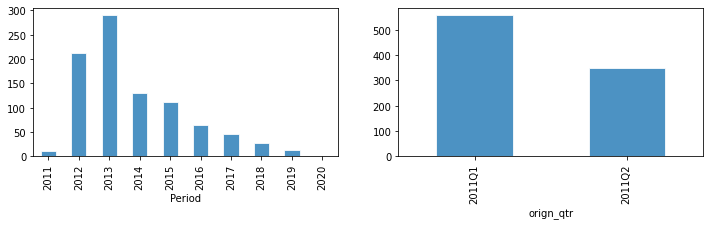

In [ ]:
# set aside numerical features 
for_correlations = data.drop(['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds','New_Int_rt','Dt_zero_BAL','CD_Zero_BAL','collateral_Deficiency', 'prior_upb','orig_loan_term', 'Dt_Lst_Pi', 'cd_msa', 'New_Int_rt', 'period_diff', 'taxes_ins_costs', 'misc_costs', 'zb_removal_upb', 'dlq_acrd_int', 'cnt_borr', 'dti', 'Non_MI_Recoveries', 'Expenses', 'maint_pres_costs', 'ppmt_pnlty', 'prod_type'],axis=1)
df_num = data.select_dtypes(include = ['float64', 'int64'])
df_num.head()


# Bar plots of the "Period" // The as-of month for loan information contained in the loan record.
fig1, ax1 = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 6))

df_num['Period'] = pd.to_datetime(df_num['Period'], format='%Y%m')
plt.subplot(2, 2, 1)
df_num['Period'].groupby([df_num['Period'].dt.to_period('Y')]).count().plot(kind='bar', edgecolor='white', alpha = 0.8)

#Bar plots of "origin_qtr" // Quarted period when the loan was originated
plt.subplot(2, 2, 2)
data['orign_qtr'].groupby([data['orign_qtr'].dt.to_period('Q')]).count().plot(kind='bar', edgecolor='white', alpha = 0.8)
# plt.show()
# # ax[0,0].plot(df_num['Period'].groupby([df_num['Period'].dt.to_period('Y')]).count().to_list(), kind='bar') #grouping. by year (Y) or by month (M)
# plt.subplot(4,2,3)
ax1[0].hist(data['st'][:20], bins=20, edgecolor='white', alpha = 0.8)
# ax1[0].set_xticks(ticks = pd.unique(data['st'][:20]), rotation='vertical', size =6)

# plt.subplot(4,2,4)
ax1[1].hist(data['st'][20:45], bins=25, edgecolor='white', alpha = 0.8)
# ax1[0].set_xticks(ticks = pd.unique(data['st'][20:45]), rotation='vertical', size =6)



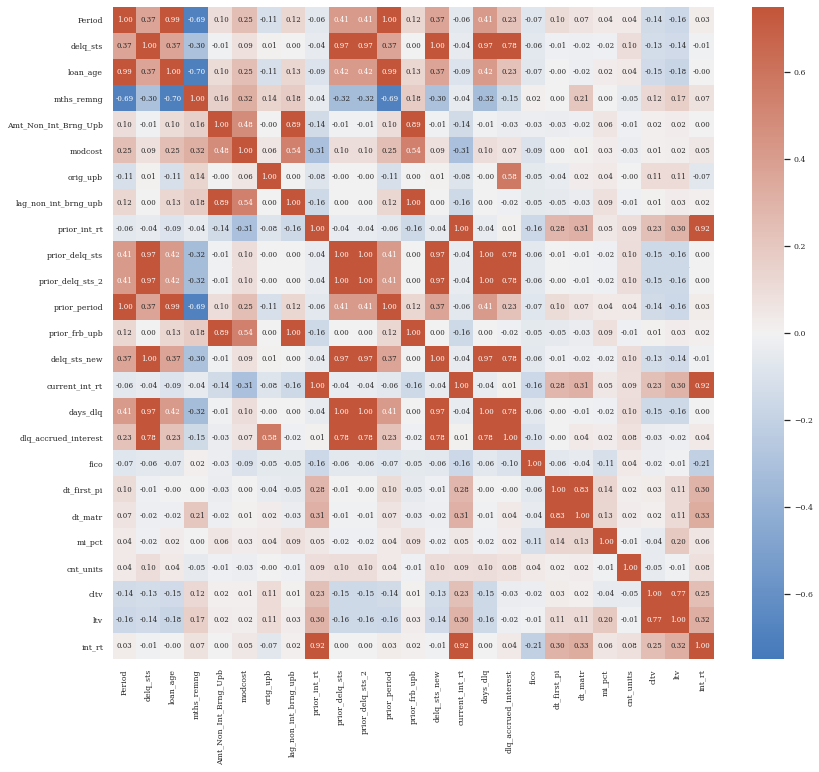

In [ ]:
# Investigating the correlations between numerical variables
for_correlations.head()
plt.figure(figsize=(12,12))
data_numerical = for_correlations.select_dtypes(include = ['float64', 'int64']).drop('legal_costs', axis=1)
sns.heatmap(data_numerical.corr(method='spearman'),vmin=-0.75,vmax=0.75,center=0, cmap=sns.diverging_palette(250, 20, as_cmap=True),annot=True, fmt='.2f', annot_kws ={'fontsize':'small'})
plt.savefig('/content/drive/My Drive/final_models/correlations.png', transparent=True)

In [ ]:
# Record p-values for two sided test Spearmn correlation. 
np.set_printoptions(suppress=True, precision=100)
from scipy import stats
from  itertools import combinations


# rho, pval = stats.spearmanr(data_numerical)
# plt.figure(figsize=(12,12))
# # sns.heatmap(pval, vmin=-0.75,vmax=0.75,center=0, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=16), annot=True)
# # np.mean(pval)

# convert two features from float64 to int
data_numerical['legal_costs'] = data_numerical['legal_costs'].astype(int)
data_numerical['days_dlq'] = data_numerical['days_dlq'].astype(int)

# take only continuous variables
for_p_values_continuous = data_numerical.select_dtypes(include='float64')
cc = list(combinations(for_p_values_continuous.columns,2))

p_values = {}
for pair in cc:
    p_values[pair] = np.array([stats.spearmanr(for_p_values_continuous[pair[0]],for_p_values_continuous[pair[1]])])

# take only integer values
for_p_values_int = data_numerical.select_dtypes(include='int64')
cc_int = list(combinations(for_p_values_int.columns,2))

p_values_int = {}
for pair in cc_int:
    p_values_int[pair] = np.array([stats.spearmanr(for_p_values_int[pair[0]],for_p_values_int[pair[1]])])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for_correlations['orig_loan_term'] = data['orig_loan_term']
for_correlations['cnt_borr'] = data['cnt_borr']
for_correlations['LGD'] = data['LGD']
for_correlations.to_csv('/content/drive/My Drive/DATA/data.xlsx', index=False)

####Property characteristics

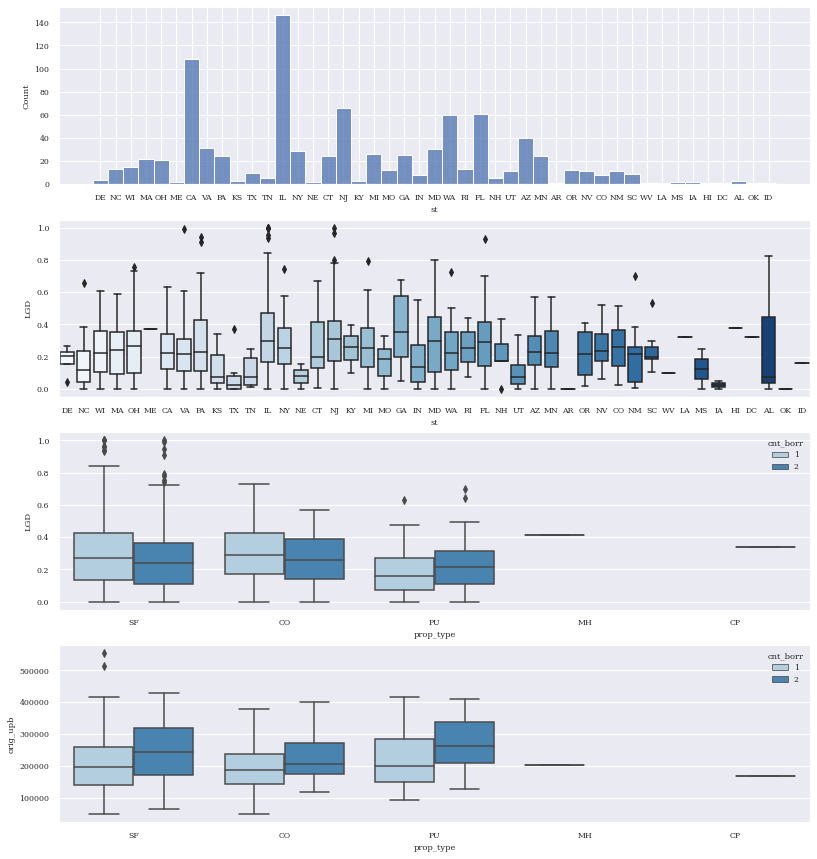

In [ ]:
# Two variables that are related to properties 
# plt data['st'] (where it is located), data['cnt_units'] (number of units), data['occpy_sts'] (occupancy status), data['orig_loan_term'], 
sns.set(font_scale=0.7, font = 'serif') 
properties_fig, properties_ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 15))

sns.histplot(data=data, x= 'st', ax=properties_ax[0], palette = ["Blues"])
# # b.set_xticklabels(b.get_xticks(), size = 10)

sns.boxplot(x="st", y="LGD", data=data, ax=properties_ax[1], palette ="Blues")

# sns.histplot(data=data, x= 'prop_type', ax=properties_ax[2], palette = ['deepskyblue'])

sns.boxplot(x='prop_type', y='LGD', data=data, hue='cnt_borr', ax=properties_ax[2], palette="Blues")
sns.boxplot(x='prop_type', y='orig_upb', data=data, hue='cnt_borr', ax=properties_ax[3], palette="Blues")
# sns.boxplot(x='cnt_units', y='orig_upb', hue = 'cnt_borr', data = data,ax=properties_ax[3], palette="Blues")


plt.savefig('/content/drive/My Drive/final_models/property.png', transparent=True)


In [ ]:
# LGD values grouped by variables 
# calculating lgds for "channel"
lgd_retail = [data['LGD'].loc[(data['channel'] == 'R') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_broker = [data['LGD'].loc[(data['channel'] == 'B') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_correspondent = [data['LGD'].loc[(data['channel'] == 'C') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]


all_lgd = [pd.concat([dataset for dataset in lgd_retail]), pd.concat([dataset for dataset in lgd_broker]), pd.concat([dataset for dataset in lgd_correspondent])]
# clear_output()
# loan_purpose
lgd_N = [data['LGD'].loc[(data['loan_purpose'] == 'N') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_C = [data['LGD'].loc[(data['loan_purpose'] == 'C') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_P = [data['LGD'].loc[(data['loan_purpose'] == 'P') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_purpose = [pd.concat([dataset for dataset in lgd_N]), pd.concat([dataset for dataset in lgd_C]), pd.concat([dataset for dataset in lgd_P])]

# property type 
lgd_SF = [data['LGD'].loc[(data['prop_type'] == 'SF') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins] #single family home
lgd_CO = [data['LGD'].loc[(data['prop_type'] == 'CO') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins] #condo
lgd_PU = [data['LGD'].loc[(data['prop_type'] == 'PU') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins] #planned unit development
lgd_MH = [data['LGD'].loc[(data['prop_type'] == 'MH') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins] #manufactured home
lgd_CP = [data['LGD'].loc[(data['prop_type'] == 'CP') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins] #cooperative share
all_lgd_PROP_TYPE = [pd.concat([dataset for dataset in lgd_SF]), pd.concat([dataset for dataset in lgd_CO]), pd.concat([dataset for dataset in lgd_PU]), pd.concat([dataset for dataset in lgd_MH]), pd.concat([dataset for dataset in lgd_CP])]

#loan-to-value ratio 
lgd_low = [data['LGD'].loc[(data['ltv'] <= 46) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_middle = [data['LGD'].loc[((data['ltv'] > 46) & (data['ltv'] <= 66)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_high_middle = [data['LGD'].loc[((data['ltv'] > 66) & (data['ltv'] <= 85)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_low_high = [data['LGD'].loc[((data['ltv'] > 86) & (data['ltv'] <= 106)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_high_high = [data['LGD'].loc[((data['ltv'] > 106) & (data['ltv'] <= 125)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_LTV = [pd.concat([dataset for dataset in lgd_low]), pd.concat([dataset for dataset in lgd_middle]), pd.concat([dataset for dataset in lgd_high_middle]), pd.concat([dataset for dataset in lgd_low_high]), pd.concat([dataset for dataset in lgd_high_high])]

#Mortgage insurance percentage (mi_pct):
lgd_mi_pct_low =  [data['LGD'].loc[(data['mi_pct'] <= 10) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_mi_pct_middle = [data['LGD'].loc[((data['mi_pct'] > 10) & (data['mi_pct'] <= 20)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_mi_pct_high_middle = [data['LGD'].loc[((data['mi_pct'] > 20) & (data['mi_pct'] <= 30)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_mi_pct_high = [data['LGD'].loc[((data['mi_pct'] > 30) & (data['mi_pct'] <= 40)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_mi_pct = [pd.concat([dataset for dataset in lgd_mi_pct_low]), pd.concat([dataset for dataset in lgd_mi_pct_middle]), pd.concat([dataset for dataset in lgd_mi_pct_high_middle]), pd.concat([dataset for dataset in lgd_mi_pct_high])]

# Changes in interest rate
rate_unchanged = [data['LGD'].loc[(data['New_Int_rt'] == data['int_rt']) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
rate_changed = [data['LGD'].loc[(data['New_Int_rt'] != data['int_rt']) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_interest_rate = [pd.concat([dataset for dataset in rate_unchanged]), pd.concat([dataset for dataset in rate_changed])]



#UPB at origination date of the mortgage 
lgd_orig_upb_lowest =  [data['LGD'].loc[(data['orig_upb'] <= 100000) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_orig_upb_low_middle = [data['LGD'].loc[((data['orig_upb'] > 100000) & (data['orig_upb'] <= 200000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_orig_upb_high_middle = [data['LGD'].loc[((data['orig_upb'] > 200000) & (data['orig_upb'] <= 300000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_orig_upb_low_high = [data['LGD'].loc[((data['orig_upb'] > 300000) & (data['orig_upb'] <= 400000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_orig_upb_high_high = [data['LGD'].loc[((data['orig_upb'] > 400000) & (data['orig_upb'] <= 500000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_orig_upb_top = [data['LGD'].loc[((data['orig_upb'] > 500000) & (data['orig_upb'] <= 554000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_orig_upb = [pd.concat([dataset for dataset in lgd_orig_upb_lowest]), pd.concat([dataset for dataset in lgd_orig_upb_low_middle]), pd.concat([dataset for dataset in lgd_orig_upb_high_middle]), pd.concat([dataset for dataset in lgd_orig_upb_low_high]), pd.concat([dataset for dataset in lgd_orig_upb_high_high]), pd.concat([dataset for dataset in lgd_orig_upb_top])]

#Prior UPB, UPB as of period prior to the current reporting period 
lgd_prior_upb_lowest = [data['LGD'].loc[(data['prior_upb'] <= 100000) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_prior_upb_low_middle = [data['LGD'].loc[((data['prior_upb'] > 100000) & (data['prior_upb'] <= 200000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_prior_upb_high_middle = [data['LGD'].loc[((data['prior_upb'] > 200000) & (data['prior_upb'] <= 300000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_prior_upb_low_high = [data['LGD'].loc[((data['prior_upb'] > 300000) & (data['prior_upb'] <= 400000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_prior_upb_high_high = [data['LGD'].loc[((data['prior_upb'] > 400000) & (data['prior_upb'] <= 500000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_prior_upb_top = [data['LGD'].loc[((data['orig_upb'] > 500000) & (data['orig_upb'] <= 550734)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_prior_upb = [pd.concat([dataset for dataset in lgd_prior_upb_lowest]), pd.concat([dataset for dataset in lgd_prior_upb_low_middle]), pd.concat([dataset for dataset in lgd_prior_upb_high_middle]), pd.concat([dataset for dataset in lgd_prior_upb_low_high]), pd.concat([dataset for dataset in lgd_prior_upb_high_high]), pd.concat([dataset for dataset in lgd_prior_upb_top])]



In [ ]:
cltv_changes = [data['LGD'].loc[(data['cltv'] < data['ltv']) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
len(pd.concat([dataset for dataset in cltv_changes]))

0

##Loan characteristics

No handles with labels found to put in legend.


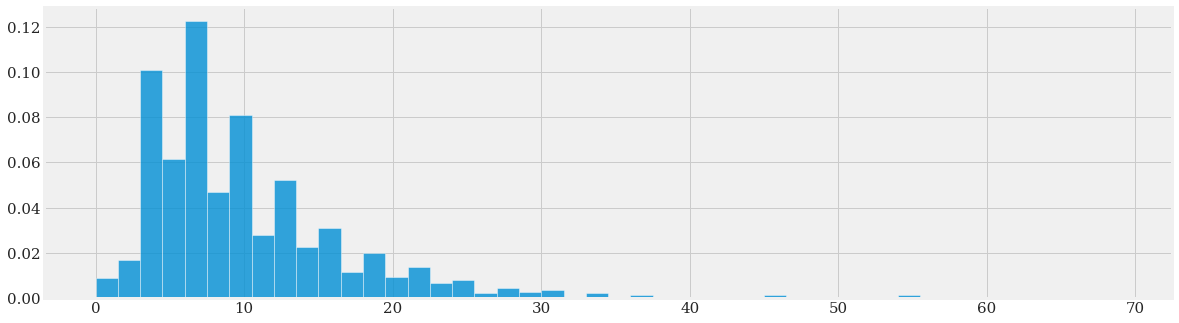

In [ ]:
# create just separate plots
plt.figure(figsize=(18,5))

plt.hist(data['prior_delq_sts'], bins = len(pd.unique(data['prior_delq_sts'])), density=True, alpha = 0.8, linewidth=0.5, edgecolor='white') #should I add more bins to make it more visible?
plt.yticks(fontsize=15) 
plt.xticks(fontsize=15) 
plt.legend(fontsize='xx-large')

plt.savefig('/content/drive/My Drive/final_models/prior-delq-sts.png', transparent=True)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


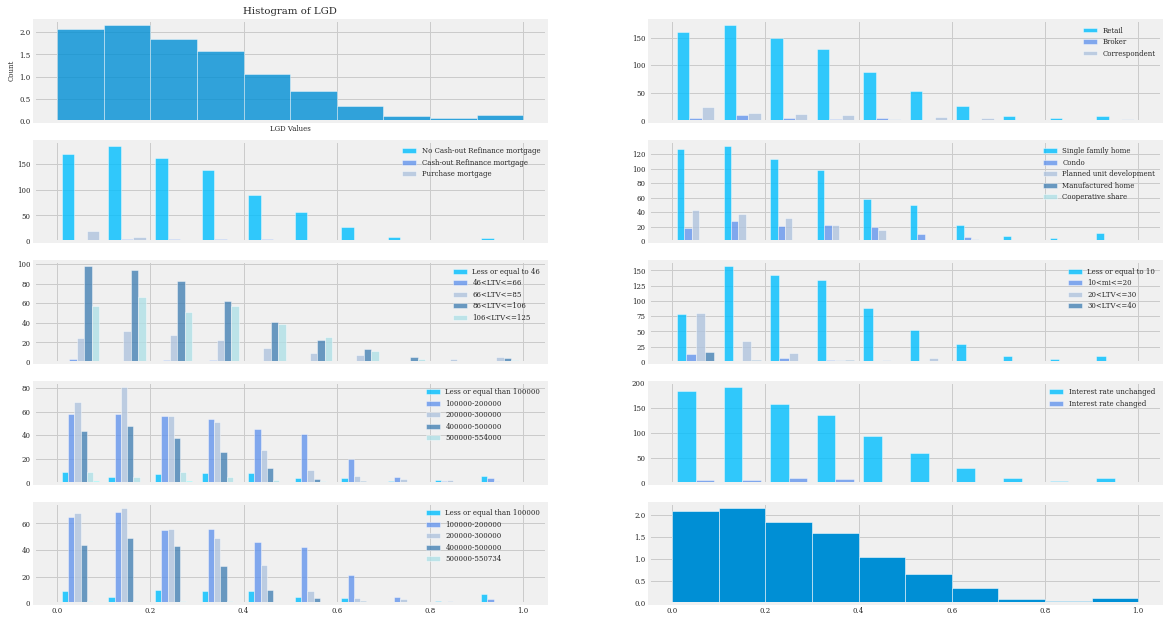

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(nrows=5, ncols=2, sharex=True, figsize=(18, 10))
n, bins, _ = plt.hist(y, bins=10, density=True, alpha = 1, linewidth=0.5, edgecolor='white')
ax[0,0].hist(y, bins=10, density=True, alpha = 0.8, linewidth=0.5, edgecolor='white')
ax[0,0].set_title('Histogram of LGD')
ax[0,0].set_xlabel('LGD Values', {'fontsize':'medium'})
ax[0,0].set_ylabel('Count', {'fontsize':'medium'})


my_cmap = sns.light_palette("Navy", as_cmap=True)
# colors = np.linspace(0,1,3)
ax[0,1].hist(all_lgd, bins, density=False,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue'], edgecolor='white', alpha = 0.8, label= ['Retail', 'Broker', 'Correspondent']) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[0,1].legend()

ax[1,0].hist(all_lgd_purpose, bins, density=False,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue'], edgecolor='white', alpha = 0.8, label= ['No Cash-out Refinance mortgage', 'Cash-out Refinance mortgage', 'Purchase mortgage']) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[1,0].legend()

ax[1,1].hist(all_lgd_PROP_TYPE, bins, density=False,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue'], edgecolor='white', alpha = 0.8, label= ['Single family home', 'Condo', 'Planned unit development', 'Manufactured home', 'Cooperative share']) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[1,1].legend()

ax[2,0].hist(all_lgd_LTV, bins, density=False,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue'], edgecolor='white', alpha = 0.8, label= ['Less or equal to 46', '46<LTV<=66', '66<LTV<=85', '86<LTV<=106', '106<LTV<=125']) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[2,0].legend()

ax[2,1].hist(all_lgd_mi_pct,density=False, color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue'], edgecolor='white', alpha = 0.8, label= ['Less or equal to 10', '10<mi<=20', '20<LTV<=30', '30<LTV<=40']) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[2,1].legend()

ax[3,1].hist(all_lgd_interest_rate,density=False, color = ['deepskyblue', 'cornflowerblue'], edgecolor='white', alpha = 0.8, label= ['Interest rate unchanged', 'Interest rate changed' ]) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[3,1].legend()

ax[3,0].hist(all_lgd_orig_upb,density=False, color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue', 'aqua'], edgecolor='white', alpha = 0.8, label= ['Less or equal than 100000', '100000-200000', '200000-300000', '400000-500000', '500000-554000' ]) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[3,0].legend()

ax[4,0].hist(all_lgd_prior_upb,density=False, color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue', 'aqua'], edgecolor='white', alpha = 0.8, label= ['Less or equal than 100000', '100000-200000', '200000-300000', '400000-500000', '500000-550734' ]) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[4,0].legend()


In [ ]:
#Investigating delinquency: delq_sts, prior_delq_sts, days_dlq, dlq_accrued_interest
#drop delq_sts_new as it is the same thing as delq_sts
# dlq_acrd_int should it be included in the analysis?

# pd.Series(data['delq_sts'] == data['days_dlq']).value_counts()


all_lgd_delq_sts_lower = [data['LGD'].loc[(data['delq_sts'] <= 20) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_delq_sts_lower_middle = [data['LGD'].loc[((data['delq_sts'] > 20) & (data['delq_sts'] <= 40)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_delq_sts_higher_middle = [data['LGD'].loc[((data['delq_sts'] > 40) & (data['delq_sts'] <= 70)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_delq_sts = [pd.concat([dataset for dataset in all_lgd_delq_sts_lower]), pd.concat([dataset for dataset in all_lgd_delq_sts_lower_middle]), pd.concat([dataset for dataset in all_lgd_delq_sts_higher_middle])]

all_lgd_days_dlq_lower = [data['LGD'].loc[(data['days_dlq'] <= 500) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_days_dlq_lower_middle = [data['LGD'].loc[((data['days_dlq'] > 500) & (data['days_dlq'] <= 1000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_days_dlq_higher_middle = [data['LGD'].loc[((data['days_dlq'] > 1000) & (data['days_dlq'] <= 1500)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_days_dlq_lower_high = [data['LGD'].loc[((data['days_dlq'] > 1500) & (data['days_dlq'] <= 2100)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_days_dlq = [pd.concat([dataset for dataset in all_lgd_days_dlq_lower]), pd.concat([dataset for dataset in all_lgd_days_dlq_lower_middle]), pd.concat([dataset for dataset in all_lgd_days_dlq_higher_middle]), pd.concat([dataset for dataset in all_lgd_days_dlq_lower_high])]

all_lgd_accrued_interest_lower = [data['LGD'].loc[(data['dlq_accrued_interest'] <= 15000) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_accrued_interest_lower_middle = [data['LGD'].loc[((data['dlq_accrued_interest'] > 15000) & (data['dlq_accrued_interest'] <= 30000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_accrued_interest_higher_middle = [data['LGD'].loc[((data['dlq_accrued_interest'] > 30000) & (data['dlq_accrued_interest'] <= 45000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_accrued_interest_lower_high = [data['LGD'].loc[((data['dlq_accrued_interest'] > 45000) & (data['dlq_accrued_interest'] <= 60000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_accrued_interest_high_high = [data['LGD'].loc[((data['dlq_accrued_interest'] > 60000) & (data['dlq_accrued_interest'] <= 78108)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_accrued_interest = [pd.concat([dataset for dataset in all_lgd_accrued_interest_lower]), pd.concat([dataset for dataset in all_lgd_accrued_interest_lower_middle]), pd.concat([dataset for dataset in all_lgd_accrued_interest_higher_middle]), pd.concat([dataset for dataset in all_lgd_accrued_interest_lower_high]), pd.concat([dataset for dataset in all_lgd_accrued_interest_high_high])]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Delinquency accrued interest')

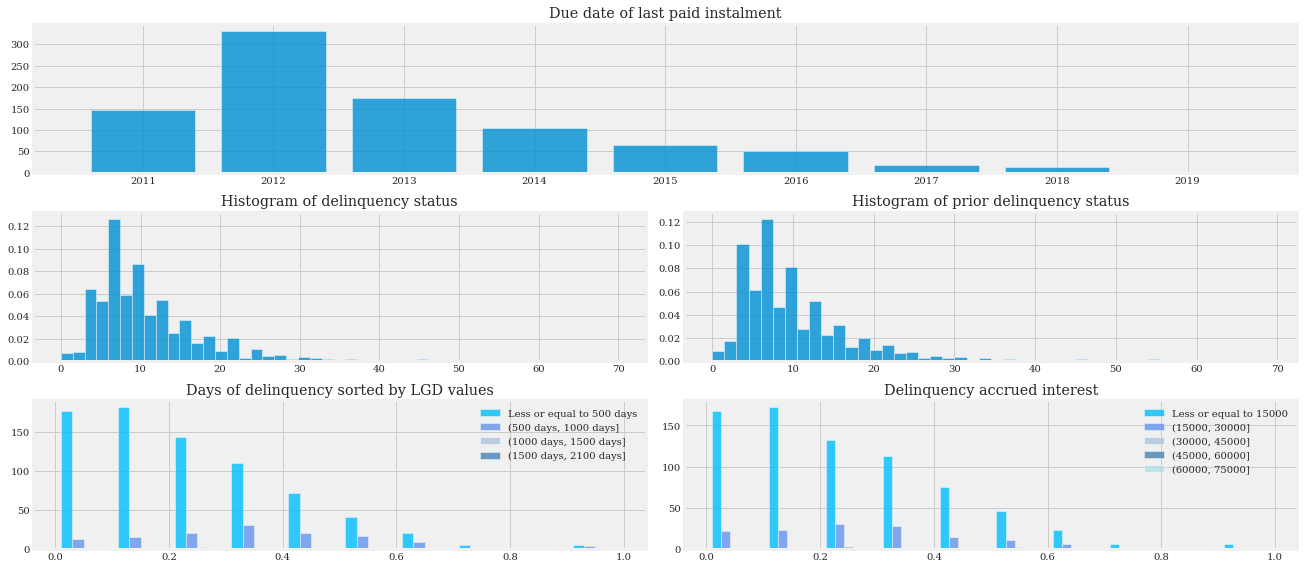

In [ ]:

# # delq_f = plt.figure(figsize=(18,10))
# fig_delq, delq_f = plt.subplots(ncols=2, nrows=2, figsize=(18,10))
# # delq_ax1 = delq_f.add_subplot(321)
# delq_f[0,0].hist(data['delq_sts'], bins = len(pd.unique(data['delq_sts'])), density=True, alpha = 0.8, linewidth=0.5, edgecolor='white') #should I add more bins to make it more visible?
# delq_f[0,0].set_title('Histogram of deliquency status')

# # delq_ax2 = delq_f.add_subplot(322)
# delq_f[0,1].hist(data['prior_delq_sts'], bins = len(pd.unique(data['prior_delq_sts'])), density=True, alpha = 0.8, linewidth=0.5, edgecolor='white') #should I add more bins to make it more visible?
# delq_f[0,1].set_title('Histogram of prior deliquency status')


# # delq_ax3 = delq_f.add_subplot(3,1,2)
# delq_f[1,0].hist(all_lgd_days_dlq, bins, density=False,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue'], edgecolor='white', alpha = 0.8, label= ['Less or equal to 500 days', '(500 days, 1000 days]', '(1000 days, 1500 days]', '(1500 days, 2100 days]'])
# delq_f[1,0].legend()
# delq_f[1,0].set_title('Days of delinquency sorted by LGD values')

# # delq_ax4 = delq_f.add_subplot(2,2,1)
# delq_f[1,1].hist(all_lgd_accrued_interest, bins, density=False,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue'], edgecolor='white', alpha = 0.8, label= ['Less or equal to 15000', '(15000, 30000]', '(30000, 45000]', '(45000, 60000]', '(60000, 75000]'])
# delq_f[1,1].legend()
# delq_f[1,1].set_title('Delinquency accrued interest')




fig3 = plt.figure(constrained_layout=True, figsize=(18,10))
gs = fig3.add_gridspec(4, 4)


f3_ax1 = fig3.add_subplot(gs[0, :])
grouped = pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m').groupby(pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m').dt.year).groups.keys()
f3_ax1.bar(grouped ,height=[len(element) for element in pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m').groupby(pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m').dt.year).groups.values()], alpha = 0.8, linewidth=0.5, edgecolor='white')
f3_ax1.set_title('Due date of last paid instalment')
f3_ax1.set_xticks([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

f3_ax2 = fig3.add_subplot(gs[1, :-2])
f3_ax2.hist(data['delq_sts'], bins = len(pd.unique(data['delq_sts'])), density=True, alpha = 0.8, linewidth=0.5, edgecolor='white') #should I add more bins to make it more visible? is it ok if y-axis is different everywhere?
f3_ax2.set_title('Histogram of delinquency status')



f3_ax3 = fig3.add_subplot(gs[1, -2:])
f3_ax3.hist(data['prior_delq_sts'], bins = len(pd.unique(data['prior_delq_sts'])), density=True, alpha = 0.8, linewidth=0.5, edgecolor='white') #should I add more bins to make it more visible?
f3_ax3.set_title('Histogram of prior delinquency status')

f3_ax4 = fig3.add_subplot(gs[2, :-2])
f3_ax4.hist(all_lgd_days_dlq, bins, density=False,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue'], edgecolor='white', alpha = 0.8, label= ['Less or equal to 500 days', '(500 days, 1000 days]', '(1000 days, 1500 days]', '(1500 days, 2100 days]'])
f3_ax4.legend()
f3_ax4.set_title('Days of delinquency sorted by LGD values')
# f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[2, -2:])
f3_ax5.hist(all_lgd_accrued_interest, bins, density=False,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue'], edgecolor='white', alpha = 0.8, label= ['Less or equal to 15000', '(15000, 30000]', '(30000, 45000]', '(45000, 60000]', '(60000, 75000]'])
f3_ax5.legend()
f3_ax5.set_title('Delinquency accrued interest')

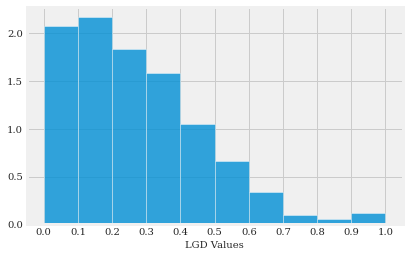

In [ ]:
# IGNORE. THIS PLOTS ARE FOR PRESENTATION PURPOSES

# fig4 = plt.figure(constrained_layout=True, figsize=(18,10))
# gs = fig4.add_gridspec(3, 3)

# f4_ax0 = fig4.add_subplot(gs[0, :])
# # n, bins, _ = plt.hist(y, bins=10, density=True, alpha = 1, linewidth=0.5, edgecolor='white')
# f4_ax0.hist(y, bins=10, density=True, alpha = 0.8, linewidth=0.5, edgecolor='white')
# f4_ax0.set_title('Histogram of LGD')
# f4_ax0.set_xlabel('LGD Values', {'fontsize':'medium'})
# f4_ax0.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# # f4_ax0.set_ylabel('Count', {'fontsize':'medium'})



# f4_ax1 = fig4.add_subplot(gs[1, :])
# grouped = pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m').groupby(pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m').dt.year).groups.keys()
# f4_ax1.bar(grouped ,height=[len(element) for element in pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m').groupby(pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m').dt.year).groups.values()], alpha = 0.8, linewidth=0.5, edgecolor='white')
# f4_ax1.set_title('Due date of last paid instalment')
# f4_ax1.set_xticks([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

# f3_ax2 = fig4.add_subplot(gs[2, :])
# f3_ax2.hist(data['delq_sts'], bins = len(pd.unique(data['delq_sts'])), density=True, alpha = 0.8, linewidth=0.5, edgecolor='white') #should I add more bins to make it more visible? is it ok if y-axis is different everywhere?
# f3_ax2.set_title('Histogram of delinquency status')

plt.hist(y, bins=10, density=True, alpha = 0.8, linewidth=0.5, edgecolor='white')
# plt.title('Histogram of LGD')
plt.xlabel('LGD Values', {'fontsize':'medium'})
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.savefig('/content/drive/My Drive/final_models/for_presentation_artwork_1.png', transparent=True)

####Borrower characteristics

In [ ]:
# fico score

all_lgd_fico_lower = [data['LGD'].loc[(data['fico'] <= 500) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_fico_lower_middle = [data['LGD'].loc[((data['fico'] > 500) & (data['fico'] <= 600)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_fico_higher_middle = [data['LGD'].loc[((data['fico'] > 600) & (data['fico'] <= 700)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_fico_lower_high = [data['LGD'].loc[((data['fico'] > 700) & (data['fico'] <= 800)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_fico_higher_high = [data['LGD'].loc[((data['fico'] > 800) & (data['fico'] <= 840)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]

all_lgd_fico = [pd.concat([dataset for dataset in all_lgd_fico_lower]), pd.concat([dataset for dataset in all_lgd_fico_lower_middle]), pd.concat([dataset for dataset in all_lgd_fico_higher_middle]), pd.concat([dataset for dataset in all_lgd_fico_lower_high]), pd.concat([dataset for dataset in all_lgd_fico_higher_high])]

#number of borrowers 
all_lgd_borr_one = [data['LGD'].loc[(data['cnt_borr'] == 1) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_borr_two = [data['LGD'].loc[(data['cnt_borr'] == 2) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_borr = [pd.concat([dataset for dataset in all_lgd_borr_one]), pd.concat([dataset for dataset in all_lgd_borr_two])]

#occupancy status
all_lgd_occpy_p = [data['LGD'].loc[(data['occpy_sts'] == 'P') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_occpy_i = [data['LGD'].loc[(data['occpy_sts'] == 'I') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_occpy_s = [data['LGD'].loc[(data['occpy_sts'] == 'S') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_occpy = [pd.concat([dataset for dataset in all_lgd_occpy_p]), pd.concat([dataset for dataset in all_lgd_occpy_i]), pd.concat([dataset for dataset in all_lgd_occpy_s])]


In [ ]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        fig4_ax3.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


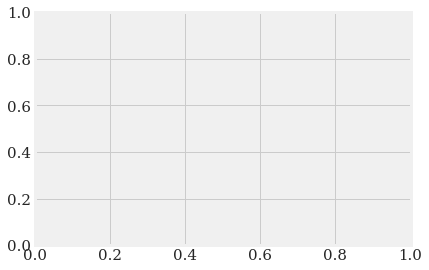

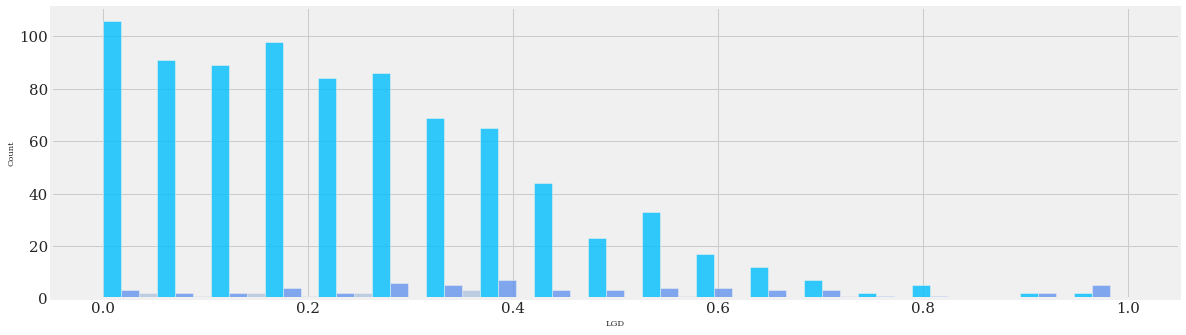

In [ ]:
# plt.figure(figsize=(18,5))
# plt.hist(data['fico'], density=True, alpha = 0.8, linewidth=0.5, edgecolor='white')
# plt.xticks(fontsize=15) 
# plt.yticks(fontsize=15) 
# plt.savefig('/content/drive/My Drive/final_models/fico.png', transparent=True)

# plt.figure(figsize=(18,5))
# plt.hist(all_lgd_fico, bins, density=False,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue'], edgecolor='white', alpha = 0.8, label= ['Less or equal to 500', '(500, 600]', '(600, 700]', '(700, 800]', '(800, 840]'])
# # fig4_ax2.set_title('Fico score sorted by LGD values')
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 
plt.legend(fontsize='xx-large')
# plt.savefig('/content/drive/My Drive/final_models/fico_sorted.png', transparent=True)

# plt.figure(figsize=(18,5))
# plt.bar([1,2], height = data['cnt_borr'].value_counts(), alpha = 0.8, linewidth=0.5, edgecolor='white')
# plt.xticks([1,2], fontsize=15)
# plt.yticks(fontsize=15) 

plt.figure(figsize=(18,5))
# plt.hist(all_lgd_borr, bins, density=False,color = ['deepskyblue', 'cornflowerblue'], edgecolor='white', alpha = 0.8, label= ['One borrower', 'Two borrowers'])
# # plt.set_title('Number of borrowers sorted by LGD values')
# plt.xticks(fontsize=15) 
# plt.yticks(fontsize=15) 
# plt.legend(fontsize='xx-large')
# plt.savefig('/content/drive/My Drive/final_models/payers.png', transparent=True)


# sns.countplot(x=data['occpy_sts'], palette=['deepskyblue', 'cornflowerblue', 'lightsteelblue'], data=data, tick_label=['Primary residence','Investment Property','Second Home'], alpha=.8)


# purpose sorted 


sns.histplot(data = data, x='LGD', hue='occpy_sts', multiple="dodge", palette=['deepskyblue', 'cornflowerblue', 'lightsteelblue'], alpha=.8)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 
plt.legend(fontsize='xx-large')
plt.savefig('/content/drive/My Drive/final_models/purpose_sorted.png', transparent=True)





/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


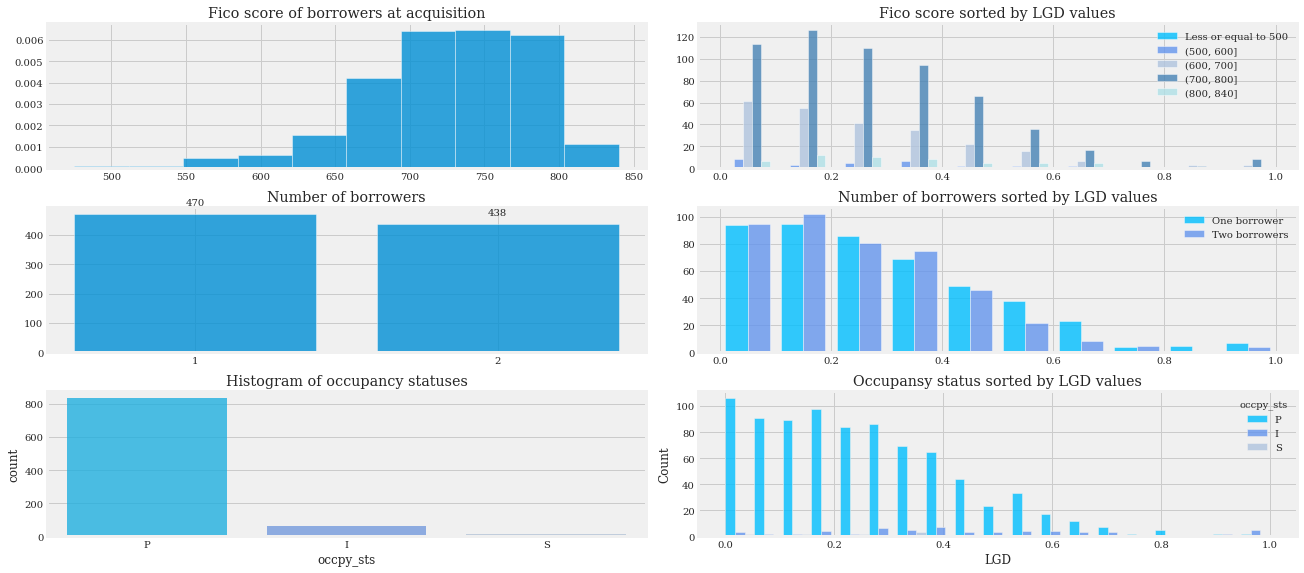

In [ ]:
# information on the borrower ((FICO score at the time of acquisition (the lowest of two borrowers) , number of borrowers (cnt_borr), intention for purchase (data['occpy_sts'] (occupancy status))))
fig4 = plt.figure(constrained_layout=True, figsize=(18,10))
gs4 = fig4.add_gridspec(4, 4)

fig4_ax1 = fig4.add_subplot(gs4[0, :-2])
fig4_ax1.hist(data['fico'], density=True, alpha = 0.8, linewidth=0.5, edgecolor='white')
fig4_ax1.set_title('Fico score of borrowers at acquisition')

fig4_ax2 = fig4.add_subplot(gs4[0, -2:])
fig4_ax2.hist(all_lgd_fico, bins, density=False,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue'], edgecolor='white', alpha = 0.8, label= ['Less or equal to 500', '(500, 600]', '(600, 700]', '(700, 800]', '(800, 840]'])
fig4_ax2.set_title('Fico score sorted by LGD values')
fig4_ax2.legend()

fig4_ax3 = fig4.add_subplot(gs4[1, :-2])
rects1 = fig4_ax3.bar([1,2], height = data['cnt_borr'].value_counts(), alpha = 0.8, linewidth=0.5, edgecolor='white')
fig4_ax3.set_xticks([1,2])
autolabel(rects1)
fig4_ax3.set_title('Number of borrowers')

fig4_ax4 = fig4.add_subplot(gs4[1, -2:])
fig4_ax4.hist(all_lgd_borr, bins, density=False,color = ['deepskyblue', 'cornflowerblue'], edgecolor='white', alpha = 0.8, label= ['One borrower', 'Two borrowers'])
fig4_ax4.set_title('Number of borrowers sorted by LGD values')
fig4_ax4.legend()

fig4_ax5 = fig4.add_subplot(gs4[2, :-2])
sns.countplot(x=data['occpy_sts'], palette=['deepskyblue', 'cornflowerblue', 'lightsteelblue'], data=data, ax=fig4_ax5, tick_label=['Primary residence','Investment Property','Second Home'], alpha=.8)
# fig4_ax5.set_xticks(['Primary residence','Investment Property','Second Home'])
fig4_ax5.set_title('Histogram of occupancy statuses')


fig4_ax6 = fig4.add_subplot(gs4[2,-2:])
# sns.histplot(data=pd.DataFrame({'P':all_lgd_occpy[0], 'I':all_lgd_occpy[1], 'S':all_lgd_occpy[2]}), ax=fig4_ax6, multiple='stack', stat="density")
sns.histplot(data = data, x='LGD', hue='occpy_sts', ax=fig4_ax6, multiple="dodge", palette=['deepskyblue', 'cornflowerblue', 'lightsteelblue'], alpha=.8)
fig4_ax6.set_title('Occupancy status sorted by LGD values')



plt.show()


In [ ]:
#create extra column that would allow to do split in stratified fashion, bins are taken from the histogram

data['stratification'] = 0
for index in range(len(bins)):
    data['stratification'] = np.where(data.LGD > bins[index], bins[index], data.stratification)

In [ ]:
# Building histograms with seaborn
import seaborn as sns
# g = sns.FacetGrid(df_num, col="fico", col_wrap=4, height=2, ylim=(0, 10))
clear_output()

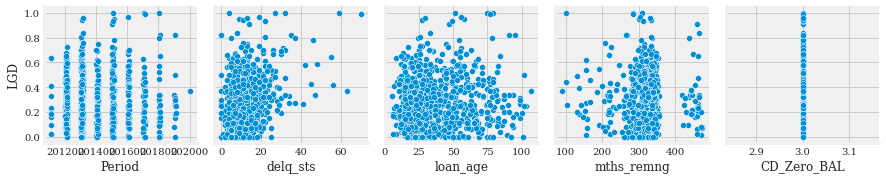

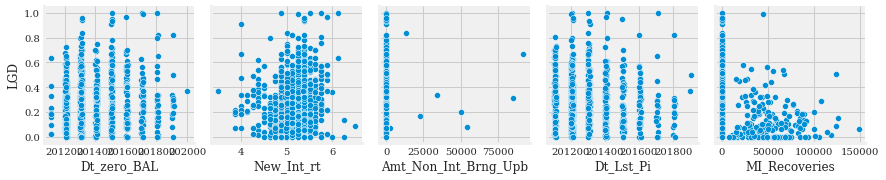

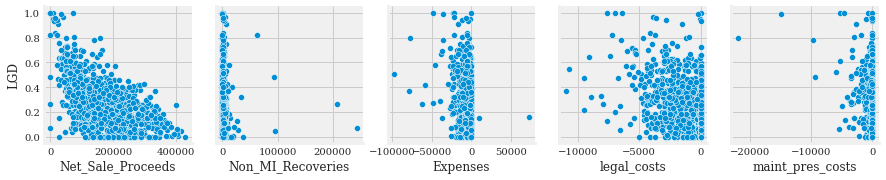

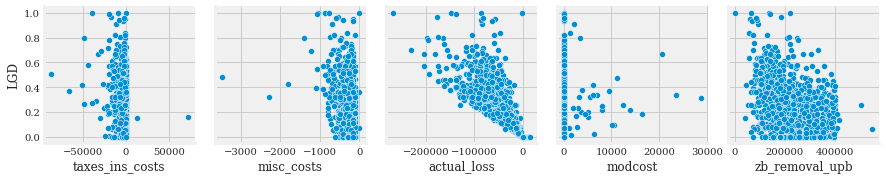

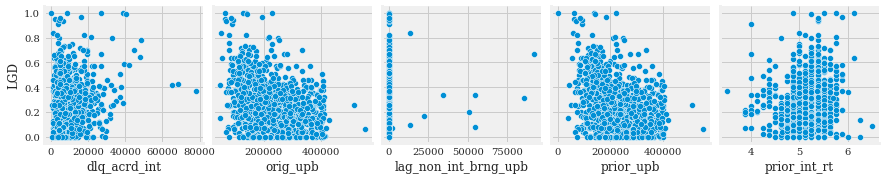

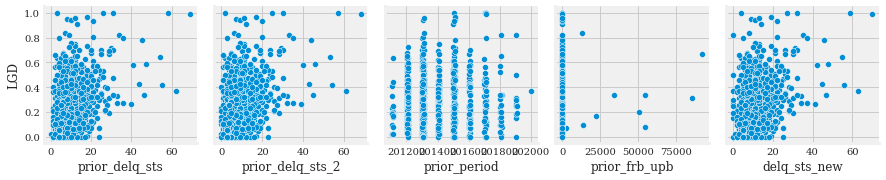

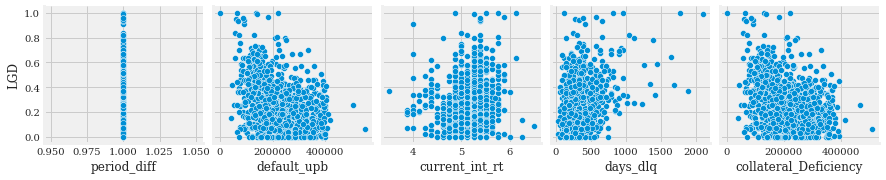

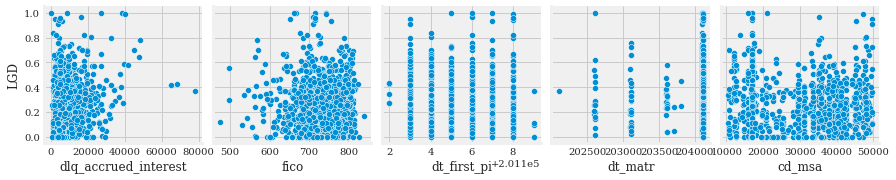

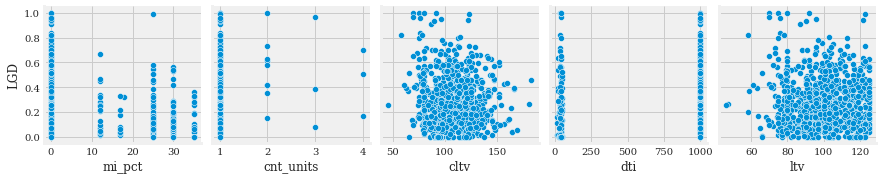

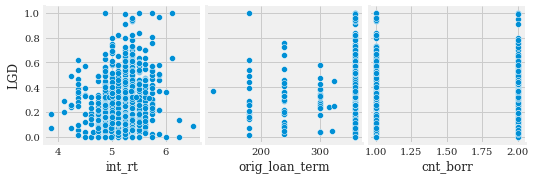

In [ ]:
import seaborn as sns
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num.drop(['stratification'], axis=1),
                x_vars=df_num.drop(['LGD','stratification'], axis=1).columns[i:i+5],
                y_vars=['LGD'])